In [ ]:
! pip install langchain-anthropic langgraph langchain_core

In [1]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("ANTHROPIC_API_KEY")

## Baeline app

In [37]:
import sys
sys.path.append('..')
import src.memory_course.prompts
import src.memory_course.utils
import src.memory_course.schemas

# Reload the module in case any changes were made
import importlib
importlib.reload(src.memory_course.prompts)
importlib.reload(src.memory_course.utils)
importlib.reload(src.memory_course.schemas)

<module 'src.memory_course.schemas' from '/Users/rlm/Desktop/Code/langgraph-memory-course/notebooks/../src/memory_course/schemas.py'>

In [10]:
# LLM 
from langchain_anthropic import ChatAnthropic
llm = ChatAnthropic(model="claude-3-5-sonnet-latest")

### Email Assistant

![Memory Course App](img/memory_course_email.png)

### Define Triage 

Create and test logic for triage.

In [13]:
from pydantic import BaseModel, Field
from typing import Literal
from src.memory_course.schemas import Router

# Define and augment LLM with structured output
llm_router = llm.with_structured_output(Router)

In [15]:
# - From user profile memory - 
full_name = "John Doe"
name = "John"
profile = "John is a senior software engineer who leads a team of 5 developers" 

# - From triage examples in memory - 
triage_no = "- Marketing newsletters\n- Spam emails\n- Mass company announcements"
triage_notify = "- Team member out sick\n- Build system notifications\n- Project status updates"
triage_email = "- Direct questions from team members\n- Meeting requests from stakeholders\n- Critical bug reports"

# - From email parsing during app ingestion - 
email_thread = """
Hi John,

I was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?

Specifically, I'm looking at:
- /auth/refresh
- /auth/validate

Thanks!
Alice"""
author = "Alice Smith <alice.smith@company.com>"
to = "John Doe <john.doe@company.com>"
subject = "Quick question about API documentation"

In [16]:
from src.memory_course.prompts import triage_system_prompt, triage_user_prompt

# Format the system prompt
triage_system_prompt_formatted = triage_system_prompt.format(
    full_name=full_name,
    name=name,
    user_profile_background=profile,
    triage_no=triage_no,
    triage_notify=triage_notify,
    triage_email=triage_email
)

# Format the user prompt
triage_user_prompt_formatted = triage_user_prompt.format(
    author=author,
    to=to,
    subject=subject,
    email_thread=email_thread)

# Mock the email input 
messages = [{"role": "system", "content": triage_system_prompt_formatted},
            {"role": "user", "content": triage_user_prompt_formatted}]

# Test
llm_router.invoke(messages)


Router(classification='respond')

### Define Tools 

Define tools that the agent can use.

In [4]:
# Define tools 
# TODO: Replace with actual tools
from langchain_core.tools import tool

@tool
def write_email(to: str, subject: str, content: str) -> str:
    """Write and send an email.

    Args:
        to: recipient email address
        subject: email subject line
        content: email body content
    """
    # Dummy response - in real app would send email
    return f"Email sent to {to} with subject '{subject}'"


@tool
def schedule_meeting(
    attendees: list[str],
    subject: str,
    duration_minutes: int,
    preferred_day: str
) -> str:
    """Schedule a calendar meeting.

    Args:
        attendees: list of attendee email addresses
        subject: meeting subject/title
        duration_minutes: length of meeting in minutes
        preferred_day: preferred day for the meeting
    """
    # Dummy response - in real app would check calendar and schedule
    return f"Meeting '{subject}' scheduled for {preferred_day} with {len(attendees)} attendees"


@tool
def check_calendar_availability(day: str) -> str:
    """Check calendar availability for a given day.

    Args:
        day: the day to check availability for
    """
    # Dummy response - in real app would check actual calendar
    return f"Available times on {day}: 9:00 AM, 2:00 PM, 4:00 PM"

# Augment the LLM with tools
tools = [write_email, schedule_meeting, check_calendar_availability]
tools_by_name = {tool.name: tool for tool in tools}
llm_with_tools = llm.bind_tools(tools)

In [38]:
# Prompt for agent
from src.memory_course.prompts import agent_prompt

full_name = "John Doe"
name = "John"
agent_prompt_formatted = agent_prompt.format(full_name=full_name, name=name)

# Mock the user's request
messages = [{"role": "system", "content": agent_prompt_formatted},
            {"role": "user", "content": "What is my availability on Tuesday?"}]

# Test the agent
result = llm_with_tools.invoke(messages)
result.tool_calls

[{'name': 'check_calendar_availability',
  'args': {'day': 'Tuesday'},
  'id': 'toolu_01X8hF5kgJrWJBsT6m7Lkug6',
  'type': 'tool_call'}]

### Build agent

Combine triage with tool calling agent 



In [39]:
# Prompt for agent
from src.memory_course.schemas import State
from src.memory_course.utils import parse_email

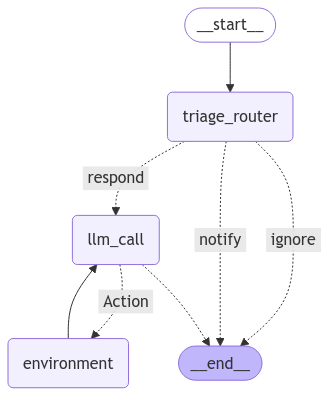

In [58]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from langchain_core.messages import HumanMessage, ToolMessage, SystemMessage

# Nodes
def triage_router(state: State) -> dict:
    """Route the email to the appropriate classification based on content analysis.
    
    Args:
        state (State): Contains email information and formatting variables
            
    Returns:
        dict: Update state with routing decision
    """
    
    # Parse the email
    author, to, subject, email_thread = parse_email(state['email_input'])

    # - From user profile memory - 
    full_name = "John Doe"
    name = "John"
    profile = "John is a senior software engineer who leads a team of 5 developers" 

    # - From triage examples in memory - 
    triage_no = "- Marketing newsletters\n- Spam emails\n- Mass company announcements"
    triage_notify = "- Team member out sick\n- Build system notifications\n- Project status updates"
    triage_email = "- Direct questions from team members\n- Meeting requests from stakeholders\n- Critical bug reports"

    # Format the prompts
    system_prompt = triage_system_prompt.format(
        full_name=full_name,
        name=name,
        user_profile_background=profile,
        triage_no=triage_no,
        triage_notify=triage_notify,
        triage_email=triage_email
    )
    
    user_prompt = triage_user_prompt.format(
        author=author,
        to=to,
        subject=subject,
        email_thread=email_thread
    )
    
    # Create message list
    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_prompt}
    ]
    
    # Get classification
    result = llm_router.invoke(messages)

    # See the agent if we want to response
    if result.classification == "respond":
        message = HumanMessage(content=f"Respond to the email {state['email_input']}")
        return {"routing_decision": result.classification, "messages": [message]}
    
    else:
        return {"routing_decision": result.classification}

def llm_call(state: State):
    """Process the current state with the LLM to determine and execute next actions.
    
    This function takes the current state and uses the LLM to decide whether to:
    1. Call a tool (write_email, schedule_meeting, check_calendar_availability)
    2. Respond directly to the user
    
    Args:
        state (State): Current workflow state containing:
            - messages: List of previous messages in the conversation
            - other context variables
            
    Returns:
        dict: Updated state with new messages, including any tool calls
            the LLM decided to make
    """

    # Format the messages
    full_name = "John Doe"
    name = "John"
    agent_prompt_formatted = agent_prompt.format(full_name=full_name, name=name)
    messages = [SystemMessage(content=agent_prompt_formatted)] + state["messages"]

    # Update the messages with the LLM call
    return {"messages": [llm_with_tools.invoke(messages)]}

def tool_node(state: dict):
    """Executes tool calls based on the LLM's decisions.
    
    This function processes any tool calls that were requested by the LLM in the previous state.
    It supports multiple tools:
    - write_email: Send emails to recipients
    - schedule_meeting: Schedule calendar meetings
    - check_calendar_availability: Check available time slots
    
    Args:
        state (dict): Current workflow state containing:
            - messages: List of messages including any tool_calls from the LLM
            
    Returns:
        dict: Updated state with tool execution results added as new messages
            Each tool result includes:
            - role: "tool"
            - content: The tool's response
            - tool_call_id: ID linking to the original tool call
    """

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}

# Conditional edge function to route to the tool node or end based upon whether the LLM made a tool call
def should_continue(state: State) -> Literal["environment", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call.
    
    This function examines the last message in the state to determine if the LLM requested
    any tool calls. If it did, the workflow should continue to the environment node to
    execute those tools. If not, the workflow should end as the LLM has provided a direct
    response to the user.
    
    Args:
        state (State): Current workflow state containing:
            - messages: List of messages, where the last message may contain tool_calls
            
    Returns:
        Literal["environment", END]: 
            - "environment": If the LLM made a tool call and we should continue processing
            - END: If no tool calls were made and we should end the workflow
    """

    messages = state["messages"]
    last_message = messages[-1]
    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "Action"
    # Otherwise, we stop (reply to the user)
    return END

def route_after_triage(state: State) -> Literal["respond", "ignore", "notify"]:
    """Determine next step based on email classification.
    
    Args:
        state (State): Contains the triage classification
            
    Returns:
        str: Next step in the workflow
    """
    classification = state["routing_decision"]
    if classification == "respond":
        print("📧 Classification: RESPOND - This email requires a response")
        return "respond"
    elif classification == "ignore":
        print("🚫 Classification: IGNORE - This email can be safely ignored")
        return "ignore"
    elif classification == "notify":
        print("🔔 Classification: NOTIFY - This email contains important information")
        return "notify"
    else:
        raise ValueError(f"Invalid classification: {classification}")

# Build workflow
agent_builder = StateGraph(State)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("triage_router", triage_router)
agent_builder.add_node("environment", tool_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "triage_router")
agent_builder.add_conditional_edges("triage_router", route_after_triage, {
    "respond": "llm_call",
    "ignore": END,
    "notify": END,
})
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        # Name returned by should_continue : Name of next node to visit
        "Action": "environment",
        END: END,
    },
)
agent_builder.add_edge("environment", "llm_call")

# Compile the agent
agent = agent_builder.compile()

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))


In [59]:
email_input = {
    "author": "Marketing Team <marketing@amazingdeals.com>",
    "to": "John Doe <john.doe@company.com>",
    "subject": "🔥 EXCLUSIVE OFFER: Limited Time Discount on Developer Tools! 🔥",
    "email_thread": """Dear Valued Developer,

Don't miss out on this INCREDIBLE opportunity! 

🚀 For a LIMITED TIME ONLY, get 80% OFF on our Premium Developer Suite! 

✨ FEATURES:
- Revolutionary AI-powered code completion
- Cloud-based development environment
- 24/7 customer support
- And much more!

💰 Regular Price: $999/month
🎉 YOUR SPECIAL PRICE: Just $199/month!

🕒 Hurry! This offer expires in:
24 HOURS ONLY!

Click here to claim your discount: https://amazingdeals.com/special-offer

Best regards,
Marketing Team
---
To unsubscribe, click here
"""
}

response = agent.invoke({"email_input": email_input})

🚫 Classification: IGNORE - This email can be safely ignored


In [60]:
email_input = {
    "author": "Alice Smith <alice.smith@company.com>",
    "to": "John Doe <john.doe@company.com>",
    "subject": "Quick question about API documentation",
    "email_thread": """Hi John,

I was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?

Specifically, I'm looking at:
- /auth/refresh
- /auth/validate

Thanks!
Alice"""
}

response = agent.invoke({"email_input": email_input})
for m in response["messages"]:
    m.pretty_print()

📧 Classification: RESPOND - This email requires a response
================================ Human Message =================================

Respond to the email {'author': 'Alice Smith <alice.smith@company.com>', 'to': 'John Doe <john.doe@company.com>', 'subject': 'Quick question about API documentation', 'email_thread': "Hi John,\n\nI was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?\n\nSpecifically, I'm looking at:\n- /auth/refresh\n- /auth/validate\n\nThanks!\nAlice"}
================================== Ai Message ==================================

[{'citations': None, 'text': "I'll help draft a response to Alice regarding her question about the API documentation. I'll use the write_email function to send a professional acknowledgment and let her know John will look into this.", 'type': 'text'}, {'id': 'toolu_01BabQWXFAb